## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
clone_changes_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"

outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/btwnChange_inCond/minPct_0.01__logfc0.1_pthresh_0.01"

# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

top_de = 3
logfcthresh=0.1
minPct = 0.01
p_thresh=0.01

In [2]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir)
donor.outdir <- file.path(outdir, "sepDonors")
dir.create(donor.outdir)

all.donor.outdir <- file.path(outdir, "allDonors")
dir.create(all.donor.outdir)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [4]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
97805 features across 22239 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Load clone_changes

In [5]:
clone_changes_f

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"

In [6]:
clone_changes <- read.csv(clone_changes_f)
row.names(clone_changes) <-clone_changes$name

In [7]:
clone_changes[c("name","change")]

,name,change
,<chr>,<chr>
0_5,0_5,regress
0_25,0_25,regress
0_8,0_8,expand
0_12,0_12,regress
0_17,0_17,expand
1_39,1_39,regress
1_1,1_1,regress
0_11,0_11,regress
0_24,0_24,regress


## Subset clones

### Add change col metadata for each clone
a) subset se by clone names
b) need to map each cell based on the clone value, create a dataframe. should be same number rows as se

In [8]:
se.filt <- subset(se , subset = name %in% clone_changes$name)
se.filt = subset(se.filt , subset = (name != "None"))

In [9]:
meta <- se.filt[[]]
meta$change <- NA
for (cell in row.names(meta)){
    curr <- clone_changes[as.character(meta[cell, "name"]),"change"]
    if(is.na(curr)){
        break
    }
    meta[cell, "change"] = curr
}

se.filt <- AddMetaData(se.filt, meta[["change"]], col.name="change")


In [10]:
clust.ids <- levels(se.filt$seurat_clusters)
don.ids <- levels(se.filt$donor)
conds <- levels(as.factor(se.filt$orig.ident))

## a) All donors

[1] "cond"
[1] "post"
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 3433 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NT5E   0.0000108727  0.1036175 0.207 0.147 0.2128332 0.0001522178
DDX60L 0.0001105454  0.1133483 0.321 0.261 1.0000000 0.0007738175
SMAD3  0.0002377694 -0.1199789 0.251 0.311 1.0000000 0.0011095905
LPIN1  0.0024651532 -0.1218815 0.316 0.355 1.0000000 0.0061092742
VPS41  0.0025609667 -0.1004583 0.152 0.191 1.0000000 0.0061092742
MAML3  0.0026182604  0.1195197 0.564 0.508 1.0000000 0.0061092742
[1] "dim response"
[1] 14  6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 7033 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
MPP7   2.457992e-05  0.1148838 0.608 0.555 0.4811519 0.0002212193
DDX60L 6.464403e-04  0.1097304 0.321 0.280 1.0000000 0.0029089814
[1] "dim response"
[1] 9 6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 8344 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TMEM163 0.0001477437  0.1001234 0.337 0.307         1 0.0001477437
[1] "dim response"
[1] 1 6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


Error in cor.test.default(x, y, method = method, use = use) : 
  not enough finite observations
[1] "cond"
[1] "pre"
[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 4727 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
HIVEP2 2.043365e-05 -0.1077515 0.897 0.898 0.3999888 8.173462e-05
DGKI   6.436239e-04  0.1627654 0.243 0.201 1.0000000 1.287248e-03
[1] "dim response"
[1] 4 6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2162 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
CNNM2    5.516536e-06  0.1130204 0.521 0.402 0.1079862 0.0001103307
TOM1L2   1.974893e-05  0.1003225 0.642 0.534 0.3865853 0.0001974893
TRAPPC10 9.894360e-05  0.1010202 0.460 0.363 1.0000000 0.0006596240
TIAM1    1.898407e-04  0.1282358 0.797 0.696 1.0000000 0.0009492033
DGKI     8.120384e-04  0.1381911 0.243 0.171 1.0000000 0.0032481535
HIVEP2   2.808756e-03 -0.1334524 0.897 0.879 1.0000000 0.0093625204
[1] "dim response"
[1] 20  6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 3755 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PLB1   1.186398e-05  0.1116741 0.504 0.407 0.2322374 0.0001305038
ZNF331 4.414388e-05  0.1199583 0.580 0.492 0.8641165 0.0002427914
[1] "dim response"
[1] 11  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



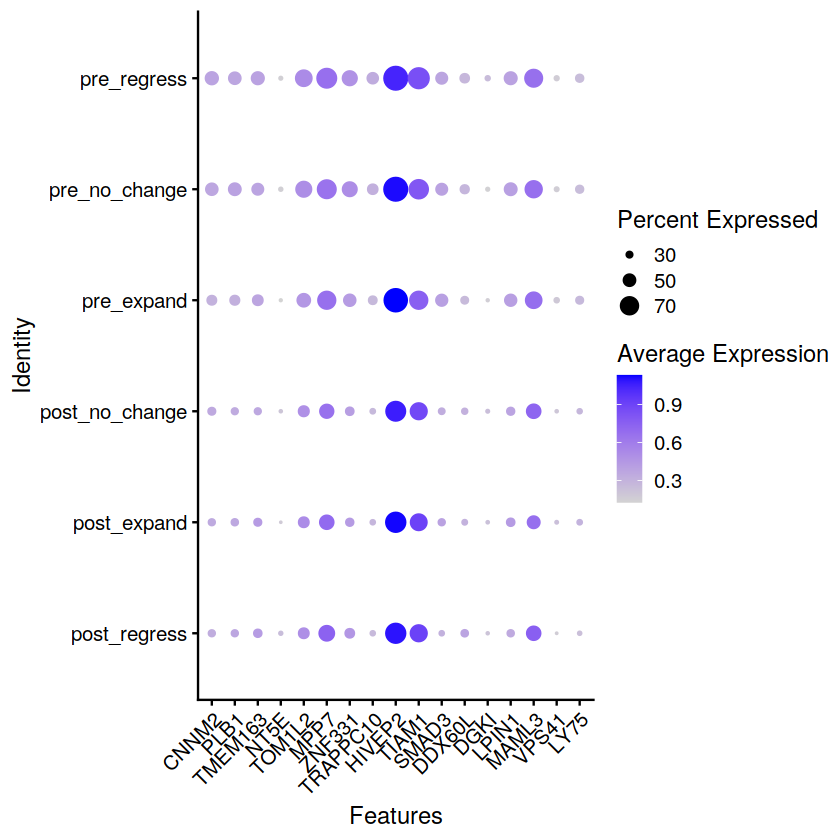

In [11]:
curr.outdir <- all.donor.outdir

Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("orig.ident", "change") ] , 1 , paste , collapse = "_" ))


all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()




for (curr.cond in conds){
    print('cond')
    print(curr.cond)
    try({
        curr.se <- subset(se.filt, subset = (orig.ident==curr.cond))

        changes <- unique(curr.se$change)
        if (length(changes)<2){
            print("Only one type of change for clone in this donor")
            print(changes)
            next
        }
        pairs <- combn(changes, 2)
        for (p in 1:ncol(pairs)){
            pair <- pairs[,p]
            print('pair')
            print(pair)
            ident.1 = paste(curr.cond, pair[[1]] ,sep="_")
            ident.2 = paste(curr.cond, pair[[2]] ,sep="_")

            curr.name <- paste(ident.1, "vs", ident.2, "cond", curr.cond, sep="_")
            #curr.dir <- paste0("donor", "_", curr.d)
            #curr.outdir <- file.path(donor.outdir, curr.dir)
            
            #dir.create(curr.outdir)

            ## Run DE
            curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                              curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                              min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
            #curr.sig <- run.de(p)
            # Add DE to global results
            names.sig <- rownames(curr.sig)
            all.names.sig <- c(all.names.sig, head(names.sig, top_de))
            all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
        }
    })
}


### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, curr.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

## b) For each donor, de for expanded vs regressed vs no change

[1] "donor 0"
[1] "cond"
[1] "post"
[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 3617 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 10  6
[1] "pairs"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1909 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
POLK          7.826074e-05  0.1617037 0.241 0.161         1  0.004978685
CTD-2410N18.5 9.667350e-05  0.1619052 0.352 0.25

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2736 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 64  6
[1] "cond"
[1] "pre"
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2281 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 5 6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1654 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
FOXO6  5.742782e-05  0.1163342 0.250 0.147         1  0.004019947
GSK3A  1.498483e-04  0.1368387 0.529 0.408         1  0.004213161
GNG2   1.805641e-04  0.1320437 0.686 0.601         1  0.004213161
CCDC15 2.686563e-04  0.1014755 0.258 0.163         1  0.004701486
CD46   3.868855e-04 -0.1314194 0.194 0.276         1  0.005058974
IL6ST  4.405207e-04  0.1036614 0.436 0.334         1  0.005058974
[1] "dim response"
[1] 70  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "donor 1"
[1] "cond"
[1] "post"
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1524 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
RNF32   4.133591e-05  0.1034736 0.152 0.085 0.8091504  0.002842741
TMEM218 6.317203e-05  0.1243430 0.346 0.243 1.0000000  0.002842741
MOB4    1.456055e-04 -0.1206889 0.150 0.227 1.0000000  0.004368165
[1] "dim response"
[1] 90  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 4297 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TDRKH 7.046935e-05 -0.1220325 0.168 0.241         1  0.001183636
MOB4  1.127272e-04 -0.1088354 0.150 0.218         1  0.001183636
NRCAM 1.536519e-03  0.1254882 0.318 0.258         1  0.008561981
MPP7  1.630853e-03  0.1009915 0.629 0.565         1  0.008561981
XRCC5 2.374258e-03 -0.1129158 0.291 0.347         1  0.009971884
[1] "dim response"
[1] 21  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 4727 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TACC1 0.0004973408 -0.1001072 0.244 0.301         1  0.002984045
[1] "dim response"
[1] 6 6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "cond"
[1] "pre"
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2446 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 8 6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 883 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
RELT     7.073028e-06  0.1151319 0.327 0.171 0.1384545  0.001301437
GGNBP2   2.738149e-05  0.1464009 0.513 0.338 0.5359927  0.001625139
ADGRE5  

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2101 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
RELT    2.014749e-05  0.1000499 0.300 0.171 0.3943871  0.001006813
KCNN3   2.426056e-05  0.1357351 0.419 0.286 0.4749005  0.001006813
ZKSCAN5 1.059186e-04  0.1203208 0.397 0.275 1.0000000  0.002930416
RBM23   1.659419e-04  0.1274395 0.525 0.401 1.0000000  0.003399947
MBD5    2.128537e-04  0.1142682 0.648 0.517 1.0000000  0.003399947
RQCD1   2.457793e-04  0.1517498 0.519 0.409 1.0000000  0.003399947
[1] "dim response"
[1] 83  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



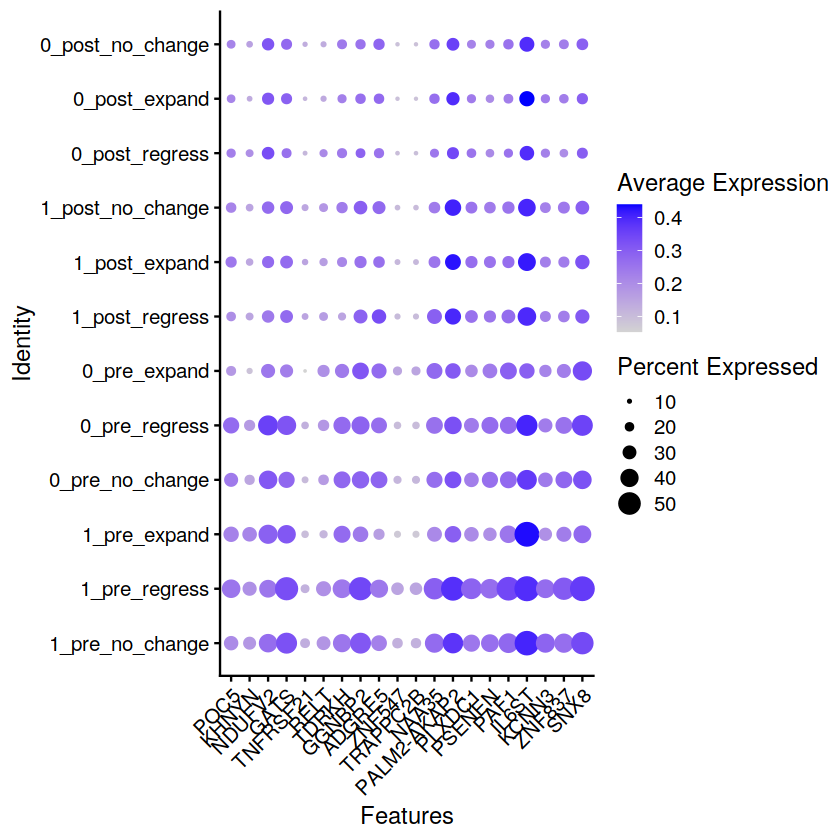

In [12]:
Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("donor", "orig.ident", "change") ] , 1 , paste , collapse = "_" ))
donors <- sort(unique(se.filt$donor))
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()
for (curr.donor in donors){
    print(paste0("donor ", curr.donor))
    for (curr.cond in conds){
        print('cond')
        print(curr.cond)
        try({
            curr.se <- subset(se.filt, subset = (donor == curr.donor) & (orig.ident==curr.cond))
            changes <- unique(curr.se$change)
            if (length(changes)<2){
                print("Only one type of change for clone in this donor")
                print(changes)
                next
            }
            pairs <- combn(changes, 2)
            for (p in 1:ncol(pairs)){
                pair <- pairs[,p]
                print("pairs")
                print(pair)
                ident.1 = paste(curr.donor, curr.cond, pair[[1]] ,sep="_")
                ident.2 = paste(curr.donor, curr.cond, pair[[2]] ,sep="_")

                curr.name <- paste(ident.1, "vs", ident.2, "donor", curr.donor, "cond", curr.cond, sep="_")
                #curr.dir <- paste0("donor", "_", curr.d)
                #curr.outdir <- file.path(donor.outdir, curr.dir)
                curr.outdir <- donor.outdir
                #dir.create(curr.outdir)

                ## Run DE
                curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                                  curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                                  min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
                #curr.sig <- run.de(p)

                # Add DE to global results
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }
        })
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

In [13]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.2            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [14]:
outdir

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/btwnChange_inCond/minPct_0.01__logfc0.1_pthresh_0.01"